In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('IMDB 50k Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.shape

(50000, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
df.duplicated().sum()

418

In [6]:
df.drop_duplicates(inplace=True, ignore_index=True)

In [7]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [8]:
df['sentiment'].value_counts()

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

<Axes: xlabel='sentiment', ylabel='count'>

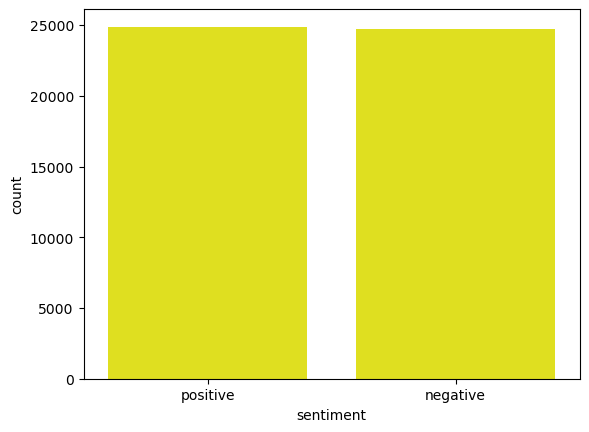

In [9]:
import seaborn as sns
sns.countplot(x='sentiment',data=df,color='yellow')

- Our target column is equally distributed, dataset is **Balanced**.

## Text Preprocessing

In [12]:
## Lowercasing

df['review'] = df['review'].str.lower()

In [13]:
df['review'][1]

'a wonderful little production. <br /><br />the filming technique is very unassuming- very old-time-bbc fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />the actors are extremely well chosen- michael sheen not only "has got all the polari" but he has all the voices down pat too! you can truly see the seamless editing guided by the references to williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. a masterful production about one of the great master\'s of comedy and his life. <br /><br />the realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. it plays on our knowledge and our senses, particularly with the scenes concerning orton and halliwell and the sets (particularly of their flat with halliwell\'s murals decorating every surface) are terribly well d

In [14]:
## HTML Tags
# Our data has html tags in text, we don't require them

import re
def remove_html_tag(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r"",text)

In [15]:
remove_html_tag('production. <br /><br />the filming ')

'production. the filming '

In [16]:
df['review'] = df['review'].apply(remove_html_tag)

### Contraction
 - words like can't, it's **expanded** to can not and it is for better interpretation.

In [18]:
# pip install contractions

In [19]:
import contractions

In [20]:
def expand_short_words(text:str) -> str: #text as input str showing string type & ->str means output as str type
    return contractions.fix(text)
    

In [21]:
expand_short_words("I'm happy don't worry it's fine")

'I am happy do not worry it is fine'

In [22]:
df['review'] = df['review'].apply(expand_short_words)

In [23]:
# Remove Punctuations

import string
exclude = string.punctuation

In [24]:
def remove_punc(text):
    return text.translate(str.maketrans('','',exclude))

In [25]:
df['review'] = df['review'].apply(remove_punc)

In [26]:
pip install symspellpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [27]:
# Spelling correction
from symspellpy import SymSpell, Verbosity

In [28]:
# Initialize Object
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

# Load Dictionary
sym_spell.load_dictionary("frequency_dictionary_en_82_765.txt", term_index=0, count_index=1)

def correct_text(text):
    words = text.split()
    corrected = []
    for word in words:
        suggestion = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        if suggestion:
            corrected.append(suggestion[0].term)
        else:
            corrected.append(word)
    return " ".join(corrected)

In [29]:
df['review'] = df['review'].apply(correct_text)

In [30]:
df.head()

,review,sentiment
0,one of they other reviewers has mentioned that...,positive
1,a wonderful little production they filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there is a family where a little boy...,negative
4,petter matters love in they time of money is a...,positive


In [31]:
from nltk.corpus import stopwords
eng_words = stopwords.words('english')

def remove_stopwords(text):
    new_text = []
    for word in text.split():
        if word not in eng_words:
            new_text.append(word)
    return " ".join(new_text)

In [32]:
df['review'] = df['review'].apply(remove_stopwords)

In [33]:
df.head()

,review,sentiment
0,one reviewers mentioned watching episode hooke...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake thinks zombie...,negative
4,petter matters love time money visually stunni...,positive


In [34]:
df.duplicated().sum()

8

In [67]:
df.drop_duplicates(inplace=True,ignore_index=True)

In [73]:
# Data Split 
X = df.drop('sentiment',axis=1)
y = df['sentiment']
X.shape,y.shape

((49574, 1), (49574,))

In [75]:
# Encoding Sentiment column
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [77]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [79]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [81]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((39659, 1), (9915, 1), (39659,), (9915,))

In [87]:
# Applying BOW

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=10000, dtype=np.int32)

In [89]:
X_train_bow = cv.fit_transform(X_train['review']).toarray()
X_test_bow = cv.transform(X_test['review']).toarray()

In [105]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_bow, y_train)
y_pred = gnb.predict(X_test_bow)

In [107]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(y_test,y_pred)

0.7225416036308623

In [109]:
confusion_matrix(y_test,y_pred)

array([[4290,  731],
       [2020, 2874]], dtype=int64)

In [111]:
# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_bow, y_train)
y_pred = mnb.predict(X_test_bow)

In [113]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(y_test,y_pred)

0.8473020675743822

In [115]:
confusion_matrix(y_test,y_pred)

array([[4301,  720],
       [ 794, 4100]], dtype=int64)

In [119]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train_bow,y_train)
y_pred = rf.predict(X_test_bow)

In [121]:
accuracy_score(y_test,y_pred)

0.8467977811396873

In [123]:
cv = CountVectorizer(ngram_range=(2,2), max_features=10000, dtype=np.int32)
X_train_bow = cv.fit_transform(X_train['review']).toarray()
X_test_bow = cv. transform(X_test['review']).toarray()
rf = RandomForestClassifier()
rf.fit(X_train_bow,y_train)
y_pred = rf.predict(X_test_bow)
accuracy_score (y_test,y_pred)

0.7703479576399395

In [125]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train['review'])
X_test_tfidf = tfidf.transform(X_test['review'])
rf = RandomForestClassifier()
rf.fit(X_train_tfidf,y_train)
y_pred = rf.predict(X_test_tfidf)
accuracy_score (y_test,y_pred)

0.8523449319213313

In [127]:
df['review']

0        one reviewers mentioned watching episode hooke...
1        wonderful little production filming technique ...
2        thought wonderful way spend time hot summer we...
3        basically family little boy jake thinks zombie...
4        petter matters love time money visually stunni...
                               ...                        
49569    thought movie right good job creative original...
49570    bad plot bad dialogue bad acting idiotic direc...
49571    catholic taught parochial elementary schools n...
49572    going disagree previous comment side martin on...
49573    one expects star trek movies high art fans exp...
Name: review, Length: 49574, dtype: object

### Word2Vec

In [130]:
import gensim
from nltk import sent_tokenize
from gensim.utils import simple_preprocess

In [132]:
story = []
for doc in df['review']:
    raw_sent = sent_tokenize(doc)
    for sent in raw_sent:
        story.append(simple_preprocess(sent))

In [136]:
model = gensim.models.Word2Vec(window=10, min_count=2)

In [138]:
model.build_vocab(story)

In [140]:
model.train(story, total_examples = model.corpus_count, epochs = model.epochs)

(27097541, 28584085)

In [142]:
len(model.wv.index_to_key)

58505

- This function will convert the complete one review in a vector.
- It cleans the review by removing unknown words, and then transforms it into a numerical vector using Word2Vec.

In [144]:
def document_vector(doc):
    # remove out of vocabulary(OOV) words
    doc = [word for word in doc.split() if word in model.wv.index_to_key]
    return np.mean(model.wv[doc], axis=0)

In [146]:
document_vector(df['review'].values[0])

array([ 0.13694407,  0.08343274, -0.44252473, -0.14099126, -0.07745222,
       -0.47882286,  0.17562672,  0.27700204, -0.59172475, -0.24912938,
       -0.27153742, -0.06834146,  0.11708456,  0.30578095, -0.2892547 ,
        0.28222   , -0.01265742, -0.6474312 ,  0.02174859, -0.32742035,
        0.5101412 ,  0.00604932,  0.02261142, -0.00792247, -0.15755339,
       -0.6270208 , -0.01086822, -0.01738214,  0.2613106 ,  0.1640283 ,
        0.5304615 ,  0.19702414,  0.09024137, -0.18691696, -0.2371169 ,
        0.26643583, -0.11341093,  0.3447266 , -0.2741125 , -0.35627583,
       -0.03174928,  0.19921778, -0.2123628 , -0.40756434,  0.54207355,
        0.15869334, -0.14259234,  0.06818452,  0.11339899,  0.1723564 ,
        0.25039083,  0.03817187,  0.12728243,  0.13542451,  0.03201818,
        0.14762685,  0.10281019, -0.42223668, -0.20523559,  0.15560575,
        0.1991398 , -0.2351943 ,  0.28172916,  0.10382085, -0.0680049 ,
        0.38243377,  0.09796777,  0.3800481 , -0.47453117,  0.42

In [148]:
from tqdm import tqdm

- Iterates over all reviews.

- Converts each review into a document vector.

- Appends each vector to list X, building a matrix of review embeddings.

In [152]:
X = []
for doc in tqdm(df['review'].values):
    X.append(document_vector(doc))

100%|████████████████████████████████████████████████████████████████████████████| 49574/49574 [12:49<00:00, 64.42it/s]


In [154]:
X = np.array(X)
X.shape

(49574, 100)

In [156]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)


In [158]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.8505295007564296